# Segmentación de clientes

Grupo formado por:
 - Javier Asensio
 - Martín de las Heras
 - Daniel Serrano
 - Elena Tornero

En esta entrega vamos a realizar una segmentación de clientes usando técnicas de clusterización. Para ello haremos comparativas entre las técnicas particionales y las técnicas basadas en densidad y usaremos la calificación de los clientes que ya se tiene para analizar si las técnicas han formado grupos homogéneos.

### Carga de librerías
Lo primero que haremos será la carga de librerías que usaremos.

In [35]:

import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from sklearn import preprocessing as pp
from sklearn import impute
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist
from prettytable import PrettyTable


A continuación cargaremos los datos que se usarán en la entrega. Son una base de datos de Lending Club, una empresa de préstamos entre particulares (peer to peer). Los usuarios pueden solicitar préstamos entre 1000 y 40000 $ a devolver entre 3 y 5 años.

Los prestamistas pueden consultar el historial de los solicitantes y decidir si prestan la cantidad solicitada, los intereses y el plazo del mismo.

In [36]:
current_path = os.getcwd()
filename='loans.csv'
df = pd.read_csv(filename, low_memory=False)
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


Como podréis comprobar tenemos 55 columnas de diferente naturaleza, en concreto

- emp_title Job title.
- emp_length Number of years in the job, rounded down. If longer than 10 years, then this is represented by the value 10.
- state Two-letter state code.
- homeownership The ownership status of the applicant's residence.
- annual_income Annual income.
- verified_income Type of verification of the applicant's income.
- debt_to_income Debt-to-income ratio.
- annual_income_joint If this is a joint application, then the annual income of the two parties applying.
- verification_income_joint Type of verification of the joint income.
- debt_to_income_joint Debt-to-income ratio for the two parties.
- delinq_2y Delinquencies on lines of credit in the last 2 years.
- months_since_last_delinq Months since the last delinquency.
- earliest_credit_line Year of the applicant's earliest line of credit
- inquiries_last_12m Inquiries into the applicant's credit during the last 12 months.
- total_credit_lines Total number of credit lines in this applicant's credit history.
- open_credit_lines Number of currently open lines of credit.
- total_credit_limit Total available credit, e.g. if only credit cards, then the total of all the credit limits. This excludes a mortgage.
- total_credit_utilized Total credit balance, excluding a mortgage.
- num_collections_last_12m Number of collections in the last 12 months. This excludes medical collections.
- num_historical_failed_to_pay The number of derogatory public records, which roughly means the number of times the applicant failed to pay.
- months_since_90d_late Months since the last time the applicant was 90 days late on a payment.
- current_accounts_delinq Number of accounts where the applicant is currently delinquent.
- total_collection_amount_ever The total amount that the applicant has had against them in collections.
- current_installment_accounts Number of installment accounts, which are (roughly) accounts with a fixed payment amount and period. A typical example might be a 36-month car loan.
- accounts_opened_24m Number of new lines of credit opened in the last 24 months.
- months_since_last_credit_inquiry Number of months since the last credit inquiry on this applicant.
- num_satisfactory_accounts Number of satisfactory accounts.
- num_accounts_120d_past_due Number of current accounts that are 120 days past due.
- num_accounts_30d_past_due Number of current accounts that are 30 days past due.
- num_active_debit_accounts Number of currently active bank cards.
- total_debit_limit Total of all bank card limits.
- num_total_cc_accounts Total number of credit card accounts in the applicant's history.
- num_open_cc_accounts Total number of currently open credit card accounts.
- num_cc_carrying_balance Number of credit cards that are carrying a balance.
- num_mort_accounts Number of mortgage accounts.
- account_never_delinq_percent Percent of all lines of credit where the applicant was never delinquent.
- tax_liens a numeric vector
- public_record_bankrupt Number of bankruptcies listed in the public record for this applicant.
- loan_purpose The category for the purpose of the loan.
- application_type The type of application: either individual or joint.
- loan_amount The amount of the loan the applicant received.
- term The number of months of the loan the applicant received.
- interest_rate Interest rate of the loan the applicant received.
- installment Monthly payment for the loan the applicant received.
- grade Grade associated with the loan.
- sub_grade Detailed grade associated with the loan.
- issue_month Month the loan was issued.
- loan_status Status of the loan.
- initial_listing_status Initial listing status of the loan. 
- disbursement_method Dispersement method of the loan.
- balance Current balance on the loan.
- paid_total Total that has been paid on the loan by the applicant.
- paid_principal The difference between the original loan amount and the current balance on the loan.
- paid_interest The amount of interest paid so far by the applicant.
- paid_late_fees Late fees paid by the applicant.

Imprimid por pantalla el tipo de las distintas variables y los estadísticos principales.

In [37]:
df.describe()

,emp_length,annual_income,debt_to_income,annual_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,...,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
count,9183.000000,1.000000e+04,9976.000000,1.495000e+03,1495.000000,10000.00000,4342.000000,10000.00000,10000.00000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.930306,7.922215e+04,19.308192,1.279146e+05,19.979304,0.21600,36.760709,2001.29000,1.95820,22.679600,...,0.123800,16361.922500,43.272000,12.427524,476.205323,14458.916610,2494.234773,1894.448466,599.666781,0.119516
std,3.703734,6.473429e+04,15.004851,7.016838e+04,8.054781,0.68366,21.634939,7.79551,2.38013,11.885439,...,0.337172,10301.956759,11.029877,5.001105,294.851627,9964.561865,3958.230365,3884.407175,517.328062,1.813468
min,0.000000,0.000000e+00,0.000000,1.920000e+04,0.320000,0.00000,1.000000,1963.00000,0.00000,2.000000,...,0.000000,1000.000000,36.000000,5.310000,30.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,4.500000e+04,11.057500,8.683350e+04,14.160000,0.00000,19.000000,1997.00000,0.00000,14.000000,...,0.000000,8000.000000,36.000000,9.430000,256.040000,6679.065000,928.700000,587.100000,221.757500,0.000000
50%,6.000000,6.500000e+04,17.570000,1.130000e+05,19.720000,0.00000,34.000000,2003.00000,1.00000,21.000000,...,0.000000,14500.000000,36.000000,11.980000,398.420000,12379.495000,1563.300000,984.990000,446.140000,0.000000
75%,10.000000,9.500000e+04,25.002500,1.515455e+05,25.500000,0.00000,53.000000,2006.00000,3.00000,29.000000,...,0.000000,24000.000000,60.000000,15.050000,644.690000,20690.182500,2616.005000,1694.555000,825.420000,0.000000
max,10.000000,2.300000e+06,469.090000,1.100000e+06,39.980000,13.00000,118.000000,2015.00000,29.00000,87.000000,...,3.000000,40000.000000,60.000000,30.940000,1566.590000,40000.000000,41630.443684,40000.000000,4216.440000,52.980000


In [38]:
df.dtypes

emp_title                            object
emp_length                          float64
state                                object
homeownership                        object
annual_income                       float64
verified_income                      object
debt_to_income                      float64
annual_income_joint                 float64
verification_income_joint            object
debt_to_income_joint                float64
delinq_2y                             int64
months_since_last_delinq            float64
earliest_credit_line                  int64
inquiries_last_12m                    int64
total_credit_lines                    int64
open_credit_lines                     int64
total_credit_limit                    int64
total_credit_utilized                 int64
num_collections_last_12m              int64
num_historical_failed_to_pay          int64
months_since_90d_late               float64
current_accounts_delinq               int64
total_collection_amount_ever    

Vamos a seleccionar algunos de los atributos que se considerarán de interés.

In [39]:
select_columns = ['loan_amount',
                 'term', 
                 'interest_rate',
                 'installment',
                 'grade',
                 'sub_grade', 
                 'emp_length',
                 'homeownership',
                 'annual_income', 
                 'verified_income',
                 'loan_purpose', 
                 'delinq_2y',
                 'earliest_credit_line', 
                 'months_since_last_delinq',
                 'open_credit_lines',
                 'total_credit_lines',
                 'total_credit_limit', 
                 'total_credit_utilized',
                 'initial_listing_status',
                 'num_historical_failed_to_pay',
                 'months_since_90d_late',
                 'accounts_opened_24m',
                 'num_accounts_120d_past_due',
                 'num_accounts_30d_past_due',
                 'total_debit_limit',
                 'num_open_cc_accounts',
                 'num_mort_accounts',
                 'account_never_delinq_percent',
                 'balance']

Imprime por pantalla el número de nulos que tenemos por columna

In [40]:
df[select_columns].isnull().sum()

loan_amount                        0
term                               0
interest_rate                      0
installment                        0
grade                              0
sub_grade                          0
emp_length                       817
homeownership                      0
annual_income                      0
verified_income                    0
loan_purpose                       0
delinq_2y                          0
earliest_credit_line               0
months_since_last_delinq        5658
open_credit_lines                  0
total_credit_lines                 0
total_credit_limit                 0
total_credit_utilized              0
initial_listing_status             0
num_historical_failed_to_pay       0
months_since_90d_late           7715
accounts_opened_24m                0
num_accounts_120d_past_due       318
num_accounts_30d_past_due          0
total_debit_limit                  0
num_open_cc_accounts               0
num_mort_accounts                  0
a

Según el tipo de variable, completaremos con 0 o con la media. En concreto en cuanto a la duración del empleo lo completaremos con la media y las relacionadas con el número de defaults o meses desde último delito lo completaremos con 0. Se ha propuesto estas metodologías para simplificar, si quieres usar alguna técnica más avanzada, justificalo y usala.

In [41]:
cols_with_mean=['emp_length']
cols_with_zero=['months_since_last_delinq','months_since_90d_late','num_accounts_120d_past_due']

In [42]:
df[cols_with_mean] = df[cols_with_mean].fillna(df[cols_with_mean].mean())
df[cols_with_zero] = df[cols_with_zero].fillna(0)

Comprueba que tu dataframe no tiene valores faltantes.

In [43]:
df[select_columns].isnull().sum()

loan_amount                     0
term                            0
interest_rate                   0
installment                     0
grade                           0
sub_grade                       0
emp_length                      0
homeownership                   0
annual_income                   0
verified_income                 0
loan_purpose                    0
delinq_2y                       0
earliest_credit_line            0
months_since_last_delinq        0
open_credit_lines               0
total_credit_lines              0
total_credit_limit              0
total_credit_utilized           0
initial_listing_status          0
num_historical_failed_to_pay    0
months_since_90d_late           0
accounts_opened_24m             0
num_accounts_120d_past_due      0
num_accounts_30d_past_due       0
total_debit_limit               0
num_open_cc_accounts            0
num_mort_accounts               0
account_never_delinq_percent    0
balance                         0
dtype: int64

Vamos a quedarnos por un lado las categorías grade y sub_grade para evaluar el clustering que se realiza y por el otro lado el resto de las variables

In [44]:
X = df[select_columns].drop(columns=['grade','sub_grade'])
y = df[['grade', 'sub_grade']]

La valoración (grade) de los distintos préstamos serán los que marquen si hemos realizado una buena labor a la hora de agrupar a los clientes. Realiza un cruce entre el grade y el interest_rate promedio que se solicita para comprobar si están relacionados.

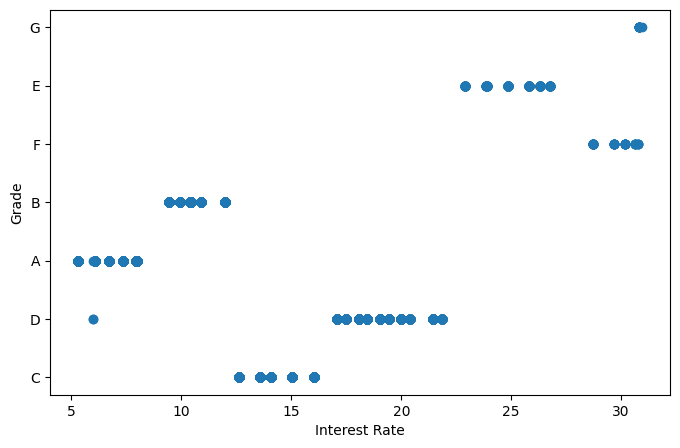

In [45]:
plt.figure(figsize=(8, 5))
plt.scatter(df['interest_rate'], df['grade'])
plt.xlabel('Interest Rate')
plt.ylabel('Grade')
plt.show()

Para las columnas no numéricas, evalúe cuantos valores distintos tenemos para considerar aplicar una técnica de one hot encoding

In [46]:
df[select_columns].select_dtypes(exclude=[np.number]).nunique()

grade                      7
sub_grade                 32
homeownership              3
verified_income            3
loan_purpose              12
initial_listing_status     2
dtype: int64

Si lo considera adecuado, aplique una técnica de one hot encoding (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html con drop_first=True) o proponga y aplique una técnica de codificación de las variables categóricas

In [47]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[['homeownership', 'verified_income', 'loan_purpose', 'initial_listing_status']] = X[['homeownership', 'verified_income', 'loan_purpose', 'initial_listing_status']].apply(le.fit_transform)
y = y.apply(le.fit_transform)

Escale los datos de forma que compartan rango de posibles valores.

In [48]:
X = pd.DataFrame(pp.StandardScaler().fit_transform(X))
X

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1.129752,1.516684,0.328439,0.598041,-0.825666,-0.980199,0.166502,1.495421,1.865941,-0.315962,...,-0.242972,1.249780,0.197535,0.0,-0.010001,-0.611898,-0.019363,-0.223097,-0.191050,1.260223
1,-1.102945,-0.659333,0.036489,-1.046902,1.146709,1.181449,-0.605925,-1.150406,-0.328509,-0.315962,...,1.211079,-0.479496,2.097216,0.0,-0.010001,-0.408652,1.203540,-0.805445,0.584516,-0.984292
2,-1.394166,-0.659333,0.932336,-1.372981,-0.825666,1.181449,-0.605925,0.172508,2.304831,-0.315962,...,-0.242972,0.794707,2.730443,0.0,-0.010001,-0.867837,-0.019363,-0.805445,-0.125510,-1.267985
3,0.508480,-0.659333,-1.141310,0.637589,-1.389202,1.181449,-0.760410,-1.150406,-0.328509,-0.315962,...,1.211079,-0.479496,-1.068919,0.0,-0.010001,-0.299502,-1.038448,-0.805445,0.584516,0.441019
4,0.644383,-0.659333,0.328439,1.053683,1.146709,1.181449,-0.683167,1.495421,-0.767399,-0.315962,...,-0.242972,-0.479496,0.514149,0.0,-0.010001,0.201085,1.407357,-0.805445,0.584516,0.699638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.741457,-0.659333,-1.015331,0.911333,1.146709,1.181449,0.444576,0.172508,2.304831,-0.315962,...,1.211079,-0.479496,1.147376,0.0,-0.010001,0.648978,0.184454,-0.223097,0.584516,0.715313
9996,-0.617576,-0.659333,1.320269,-0.371342,0.583173,-0.980199,0.645407,1.495421,-0.328509,5.535193,...,-0.242972,-0.069931,-1.385532,0.0,-0.010001,0.031713,0.592089,0.359250,-1.370785,-0.533063
9997,1.323900,-0.659333,2.290104,2.370445,1.146709,-0.980199,-0.188814,1.495421,-0.328509,2.609615,...,-0.242972,-0.479496,-0.119078,0.0,-0.010001,-0.468873,-0.223180,0.359250,-2.452209,1.320619
9998,0.741457,-0.659333,-1.421262,0.836241,-1.389202,-0.980199,0.012017,0.172508,2.304831,-0.315962,...,-0.242972,-0.479496,-0.752305,0.0,-0.010001,0.701671,0.184454,2.688640,0.584516,0.708466


Cargue la función que desarrolló de la entrega anterior para evaluar la pureza de los clusters en función de la caregorización real (que no usaremos, obviamente, en la clusterización).

In [49]:
def entropy(array):
    probabilities = array / sum(array)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

In [50]:
def cluster_purity(n_clusters, labels, targets):
    df_ = pd.DataFrame({'Labels': labels, 'target': targets})
    df_cluster = df_.groupby(['Labels']).value_counts()

    x = PrettyTable()
    x.field_names = ["Cluster", "Numero de clases", "% clase mayoritaria", "Entropia"]

    for i in range(n_clusters):
        x.add_row([i, df_cluster[i].count(), round(df_cluster[i].max()/df_cluster[i].sum(), 4), round(entropy(np.array(df_cluster[i])), 4)])
        
    return x

### Segmentación usando K-Means

La primera técnica a aplicar va a ser K-Means. Defina el número de clústers que considere como prometedor y, con la función que desarrolló en la entrega anterior, defina la pureza de los grupos obtenidos frente al grade asociado a los mismos.

In [51]:
kmeans = KMeans(n_clusters=7, 
                n_init=10, 
                max_iter=50, 
                tol=0.001, 
                random_state=42)

kmeans.fit(X)

labels = np.array(kmeans.labels_)
targets = np.array(y['grade'])

Evalúe la pureza de los clusters obtenidos usando la función que desarrolló en la entrega anterior

In [52]:
x = cluster_purity(7, labels, targets)

print(x)

+---------+------------------+---------------------+----------+
| Cluster | Numero de clases | % clase mayoritaria | Entropia |
+---------+------------------+---------------------+----------+
|    0    |        7         |        0.2903       |  2.1655  |
|    1    |        7         |        0.3043       |  2.1061  |
|    2    |        7         |        0.3264       |  2.2792  |
|    3    |        6         |        0.4226       |  1.7989  |
|    4    |        6         |        0.3728       |  1.9597  |
|    5    |        7         |        0.3235       |  2.1297  |
|    6    |        6         |        0.3379       |  2.0773  |
+---------+------------------+---------------------+----------+


### Segmentación usando técnicas jerárquicas

La segunda técnica a aplicar va a ser una técnica jerárquica. Para ello pruebe con distintas distancias de corte hasta quedarse con un número de clústers igual al seleccionado en el caso de KMeans.


In [53]:
Z = fastcluster.linkage_vector(X, method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z, columns=['clusterOne', 'clusterTwo', 'distance', 'newClusterSize'])
Z_dataFrame.tail(7)

,clusterOne,clusterTwo,distance,newClusterSize
9992,19985.0,19990.0,102.960830,4432.0
9993,4711.0,19992.0,106.745281,4433.0
9994,19988.0,19989.0,113.029122,2417.0
9995,19982.0,19993.0,129.236198,6027.0
9996,1125.0,19991.0,141.627138,1556.0
9997,19995.0,19996.0,147.591449,7583.0
9998,19994.0,19997.0,207.541334,10000.0


In [54]:
labels = fcluster(fastcluster.linkage_vector(X, method='ward', metric='euclidean'), t=7, criterion='maxclust')

Imprima por pantalla la pureza de los clústers obtenidos.

In [55]:
x = cluster_purity(7, labels-1, y['grade'])
print(x)

+---------+------------------+---------------------+----------+
| Cluster | Numero de clases | % clase mayoritaria | Entropia |
+---------+------------------+---------------------+----------+
|    0    |        7         |        0.3155       |  2.0926  |
|    1    |        6         |        0.3353       |  2.014   |
|    2    |        7         |        0.3312       |  2.1699  |
|    3    |        7         |        0.3369       |  1.9817  |
|    4    |        1         |         1.0         |   -0.0   |
|    5    |        6         |        0.3331       |  2.082   |
|    6    |        1         |         1.0         |   -0.0   |
+---------+------------------+---------------------+----------+


### Segmentación usando técnicas basadas en densidad

La tercera técnica a aplicar va a ser una técnica basada en densidad. Para ello vamos a realizar una clusterización usando un algoritmo de DBSCAN.

Tendréis que jugar con el valor de la distancia y el número de vecinos para tener un número de clusters similar al del primer caso

In [71]:
db = DBSCAN(eps=0.875, min_samples=3, metric='euclidean')
y_db = db.fit_predict(X)
print('Number of clusters: {}'.format(len(np.unique(y_db))))

Number of clusters: 8


Imprima por pantalla la pureza de los clústers obtenidos.

In [72]:
x = cluster_purity(8, y_db+1, y['grade'])
print(x)

+---------+------------------+---------------------+----------+
| Cluster | Numero de clases | % clase mayoritaria | Entropia |
+---------+------------------+---------------------+----------+
|    0    |        7         |        0.3038       |  2.1508  |
|    1    |        3         |        0.5714       |  1.4138  |
|    2    |        2         |        0.6667       |  0.9183  |
|    3    |        1         |         1.0         |   -0.0   |
|    4    |        1         |         1.0         |   -0.0   |
|    5    |        2         |         0.8         |  0.7219  |
|    6    |        2         |         0.5         |   1.0    |
|    7    |        2         |        0.6667       |  0.9183  |
+---------+------------------+---------------------+----------+


### Segmentación usando técnicas basadas en densidad 2

La cuarta y última técnica a aplicar va a ser Mean shift. 

Tendréis que jugar con el valor del bandwidth para tener un número de clusters similar al del primer caso

In [83]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.9, n_samples=1000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
y_ms = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(y_ms)
n_clusters_ = len(labels_unique)

print('Number of clusters: {}'.format(n_clusters_))

Number of clusters: 8


Imprima por pantalla la pureza de los clústers obtenidos.

In [84]:
x = cluster_purity(n_clusters_, y_ms, y['grade'])
print(x)

+---------+------------------+---------------------+----------+
| Cluster | Numero de clases | % clase mayoritaria | Entropia |
+---------+------------------+---------------------+----------+
|    0    |        7         |        0.3039       |   2.15   |
|    1    |        1         |         1.0         |   -0.0   |
|    2    |        3         |         0.5         |   1.5    |
|    3    |        2         |         0.5         |   1.0    |
|    4    |        3         |         0.6         |  1.371   |
|    5    |        1         |         1.0         |   -0.0   |
|    6    |        1         |         1.0         |   -0.0   |
|    7    |        1         |         1.0         |   -0.0   |
+---------+------------------+---------------------+----------+
